In [1]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "train_int.json" if train else "val_int.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [2]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.2.2+cu121 (NVIDIA GeForce RTX 4070)


In [3]:
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_path = "C:/Users/kimin/HSC_dataset/all_dataset/train/images"
val_path = "C:/Users/kimin/HSC_dataset/all_dataset/val/images"

train_dataset = CocoDetection(train_path, processor=processor)
val_dataset = CocoDetection(val_path, processor=processor, train=False)

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


In [4]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 15880
Number of validation examples: 1966


Image n°1359


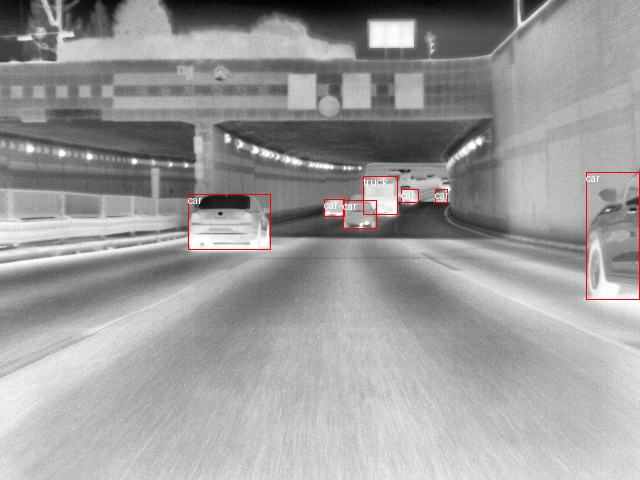

In [5]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))

# image load
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(train_path, image['file_name']))

# 이미지 모드를 'RGBA'로 변환 (필요시)
if image.mode != 'RGBA':
    image = image.convert('RGBA')

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [6]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [7]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [8]:
pixel_values, target = train_dataset[0]

In [9]:
pixel_values.shape

torch.Size([3, 800, 1066])

In [10]:
print(target)

{'size': tensor([ 800, 1066]), 'image_id': tensor([0]), 'class_labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]), 'boxes': tensor([[0.0094, 0.4198, 0.0187, 0.0854],
        [0.0312, 0.4073, 0.0219, 0.0479],
        [0.3797, 0.4198, 0.0125, 0.0604],
        [0.4688, 0.4177, 0.0156, 0.0896],
        [0.5148, 0.4208, 0.0203, 0.1042],
        [0.6227, 0.4271, 0.0609, 0.1750],
        [0.6953, 0.4292, 0.0281, 0.1667],
        [0.7688, 0.4510, 0.0437, 0.2271],
        [0.8008, 0.4490, 0.0484, 0.2438],
        [0.8313, 0.4458, 0.1094, 0.2667],
        [0.9148, 0.4417, 0.0578, 0.2833],
        [0.9688, 0.4427, 0.0594, 0.2854],
        [0.0984, 0.4646, 0.1656, 0.1750],
        [0.2156, 0.4260, 0.0531, 0.0521],
        [0.2875, 0.4271, 0.0500, 0.0625],
        [0.5711, 0.4177, 0.0578, 0.0979]]), 'area': tensor([ 1365.8125,   893.8854,   644.0417,  1193.6980,  1804.4271,  9094.3125,
         3997.5000,  8472.4795, 10068.7031, 24873.3340, 13969.0420, 14452.0732,
        24717.8750,

In [11]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader
     

In [12]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
outputs.logits.shape

torch.Size([4, 100, 9])

In [14]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# Name your wandb project and upload the final checkpoint to wandb, according to ModelCheckpoint
# Click on the output wandb run name below to see your metrics updating live in wandb
wandb_logger = WandbLogger(project='IR detection-detr', log_model=True)

# Keep track of the checkpoint with the lowest validation loss
# 여러 조건에 따른 체크포인트 저장
checkpoint_callback = ModelCheckpoint(
    monitor='validation_loss',  # validation loss를 기준으로
    mode='min',  # 손실이 가장 낮을 때 저장
    save_top_k=3,  # 성능이 가장 좋은 3개의 체크포인트 저장
    save_last=True,  # 마지막 체크포인트 저장
    filename='{epoch:02d}-{val_loss:.2f}',  # 파일 이름에 에포크와 검증 손실 포함
    dirpath='C:/Users/kimin/DETR/checkpoints'  # 체크포인트 저장 경로
)

In [15]:
from pytorch_lightning import Trainer

trainer = Trainer(    
    accelerator='gpu', 
    devices=1, 
    max_epochs=50, 
    gradient_clip_val=0.1, 
    accumulate_grad_batches=8, 
    log_every_n_steps=5, 
    logger=wandb_logger, 
    callbacks=[checkpoint_callback])

trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wasd3691 (wasd3691-seoul-national-university-ofscience-and-technology). Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.5 M    Trainable params
0         Non-trainable params
41.5 M    Total params
166.014   Total estimated model params size (MB)
0         Modules in train mode
467       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [17]:
import torch
from transformers import DetrForObjectDetection

# 체크포인트 파일 경로
checkpoint_path = "C:/Users/kimin/DETR/checkpoints/epoch=43-val_loss=0.00.ckpt"

# 체크포인트 파일 불러오기 (state_dict와 기타 정보 포함)
checkpoint = torch.load(checkpoint_path)

# 체크포인트에서 모델의 가중치 불러오기
model.load_state_dict(checkpoint['state_dict'])
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# 모델을 평가할 장치 설정 (GPU 또는 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Checkpoint에서 모델 가중치를 성공적으로 불러왔습니다.")

Checkpoint에서 모델 가중치를 성공적으로 불러왔습니다.


In [18]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [19]:
!pip install -q coco-eval

In [20]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/983 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=1.58s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.463
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.218
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.416
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.476
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [21]:
#We can use the image_id in target to know which image it is
pixel_values, target = val_dataset[1]
     

pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

torch.Size([1, 3, 800, 1066])


In [22]:
with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())

Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


In [27]:
import matplotlib.pyplot as plt

# 추론된 결과를 저장할 폴더 경로 설정
output_dir = "C:/Users/kimin/DETR/test/img_results"
os.makedirs(output_dir, exist_ok=True)

# Define the id2label mapping manually if not included in model.config
id2label = {
    0: 'person',  # Replace with actual class names
    1: 'car',
    2: 'truck',
    3: 'bus',
    4: 'bicycle',
    5: 'bike',
    6: 'extra_vehicle',
    7: 'dog',
}

# Manually set the config for your model
model.config = type('', (), {})()  # Create an empty config object
model.config.id2label = id2label  # Assign the id2label mapping


# colors for visualization
COLORS = [[0.000, 0.447, 0.741]]

def plot_results(pil_img, scores, labels, boxes, output_path):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')

    # 추론된 이미지를 저장
    plt.savefig(output_path)
    plt.close()

# 이미지 폴더 경로 (추론할 원본 이미지가 있는 폴더)
val_img_path = "C:/Users/kimin/HSC/dataset/test_open"

# 이미지 폴더에서 모든 파일을 읽음
image_files = [f for f in os.listdir(val_img_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# 추론을 위한 전처리 및 결과 저장
for image_file in image_files:
    # 이미지 경로 설정
    image_path = os.path.join(val_img_path, image_file)
    image = Image.open(image_path).convert("RGB")

    # 이미지의 크기 얻기
    width, height = image.size

    # 이미지 전처리
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    # 모델을 통해 예측 실행
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, pixel_mask=None)

    # 모델 출력 후처리
    postprocessed_outputs = processor.post_process_object_detection(outputs, target_sizes=[(height, width)], threshold=0.75)
    results = postprocessed_outputs[0]

    # 추론된 결과를 저장할 경로 생성
    output_image_path = os.path.join(output_dir, f"inferred_{image_file}")

    # 결과 시각화 및 저장
    plot_results(image, results['scores'], results['labels'], results['boxes'], output_image_path)

    print(f"Image {image_file} processed and saved at {output_image_path}")
     

Image test_open_0.png processed and saved at C:/Users/kimin/DETR/test/img_results\inferred_test_open_0.png
Image test_open_1.png processed and saved at C:/Users/kimin/DETR/test/img_results\inferred_test_open_1.png
Image test_open_10.png processed and saved at C:/Users/kimin/DETR/test/img_results\inferred_test_open_10.png
Image test_open_100.png processed and saved at C:/Users/kimin/DETR/test/img_results\inferred_test_open_100.png
Image test_open_1000.png processed and saved at C:/Users/kimin/DETR/test/img_results\inferred_test_open_1000.png
Image test_open_1001.png processed and saved at C:/Users/kimin/DETR/test/img_results\inferred_test_open_1001.png
Image test_open_1002.png processed and saved at C:/Users/kimin/DETR/test/img_results\inferred_test_open_1002.png
Image test_open_1003.png processed and saved at C:/Users/kimin/DETR/test/img_results\inferred_test_open_1003.png
Image test_open_1004.png processed and saved at C:/Users/kimin/DETR/test/img_results\inferred_test_open_1004.png
I

KeyboardInterrupt: 

In [28]:
import os
import torch
from PIL import Image
import json
import re

# 추론된 결과를 저장할 폴더 경로 설정
output_dir = "C:/Users/kimin/DETR/test/img_results"
os.makedirs(output_dir, exist_ok=True)


# Define the id2label mapping manually if not included in model.config
id2label = {
    0: 'person',  # Replace with actual class names
    1: 'car',
    2: 'truck',
    3: 'bus',
    4: 'bicycle',
    5: 'bike',
    6: 'extra_vehicle',
    7: 'dog',
}

# Manually set the config for your model
model.config = type('', (), {})()  # Create an empty config object
model.config.id2label = id2label  # Assign the id2label mapping

# 이미지 폴더 경로 (추론할 원본 이미지가 있는 폴더)
val_img_path = "C:/Users/kimin/HSC/dataset/test_open"

# 이미지 폴더에서 모든 파일을 읽음
image_files = [f for f in os.listdir(val_img_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# 추론된 결과를 저장할 텍스트 파일 경로
output_txt_path = os.path.join(output_dir, "inference_results.txt")

# 결과 저장 리스트
all_results = []

# 추론을 위한 전처리 및 결과 저장
for image_file in image_files:
    # 이미지 경로 설정
    image_path = os.path.join(val_img_path, image_file)
    image = Image.open(image_path).convert("RGB")

    # 이미지의 크기 얻기
    width, height = image.size

    # 이미지 전처리
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    # 모델을 통해 예측 실행
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, pixel_mask=None)

    # 모델 출력 후처리
    postprocessed_outputs = processor.post_process_object_detection(outputs, target_sizes=[(height, width)], threshold=0.20)
    results = postprocessed_outputs[0]

    # image_id (파일명에서 확장자 제거)
    image_id = os.path.splitext(image_file)[0]

    # 추론된 bbox, score, labels 저장
    for score, label, bbox in zip(results['scores'].tolist(), results['labels'].tolist(), results['boxes'].tolist()):
        # bbox는 [x_min, y_min, x_max, y_max] 형태이므로 width와 height를 계산해야 함
        x_min, y_min, x_max, y_max = bbox
        bbox_width = x_max - x_min
        bbox_height = y_max - y_min
        
        result_dict = {
            "image_id": image_id,
            "category_id": label,  # 이미 정의된 class id 그대로 사용
            "bbox": [round(x_min, 2), round(y_min, 2), round(bbox_width, 2), round(bbox_height, 2)],  # bbox 변환 및 소수점 둘째 자리 반올림
            "score": round(score, 2)  # 점수도 소수점 둘째 자리까지 반올림
        }
        all_results.append(result_dict)

# image_id에서 숫자를 추출하여 정렬
sorted_results = sorted(all_results, key=lambda x: int(re.findall(r'\d+', x['image_id'])[0]))

# 결과를 JSON 형식으로 .txt 파일에 저장
sorted_output_txt_path = os.path.join(output_dir, "sorted_inference_results.txt")

# 결과를 JSON 형식으로 .txt 파일에 저장
with open(sorted_output_txt_path, "w") as f:
    json.dump(all_results, f, indent=4)

print(f"Inference results saved to {output_txt_path}")

Inference results saved to C:/Users/kimin/DETR/test/img_results\inference_results.txt
